# Google Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# My Assignment Folder

In [ ]:
%cd /content/drive/MyDrive/University Tasks/ANN_assignment

# Imports and dataloader class

In [1]:
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from ANN.model import Model
from tqdm import tqdm
import pickle

Crop the image where the writing is

In [5]:
def imgPreProcess(img):
    or_img = img = np.copy(img)

    kernel = np.ones((3,3), np.uint8)
    img = cv2.dilate(img, kernel, iterations=1)
    img = cv2.erode(img, kernel, iterations=1)

    top = right = bottom = 0
    rows, cols = img.shape
    left = cols - 1
    for i in range(rows):
        for j in range(cols):
            if img[i][j] < 0.9:
                bottom = i
                if top == 0:
                    top = i
                if j < left:
                    left = j
                if j > right:
                    right = j
            else:
                or_img[i][j] = 1
    img = or_img[top:bottom, left:right]
    
    height = bottom - top
    width = right - left
    if height > width:
        offset = int((height - width) / 2)
        blank_img = np.ones((height+1, height+1))
        blank_img[0:img.shape[0], offset:offset+img.shape[1]] = img
        img = blank_img
    else:
        offset = int((width - height) / 2)
        blank_img = np.ones((width+1, width+1))
        blank_img[offset:offset+img.shape[0], 0:img.shape[1]] = img
        img = blank_img
    
    return img

Dataloader class

In [6]:
class DataLoader():
  def __init__(self, data_dir, data_array, label_array, suffle=True):
    self.data_dir = data_dir
    self.data = data_array
    self.labels = label_array
    self.data_order = np.arange(0, self.data.size, 1)
    if suffle:
      np.random.shuffle(self.data_order)
  
  def __getitem__(self, idx):
    img = cv2.imread(os.path.join(self.data_dir, str(self.data[self.data_order[idx]][0]), self.data[self.data_order[idx]]), 0) / 255
    img = imgPreProcess(img)
    img = cv2.resize(img, (net_in_img_dim, net_in_img_dim))

    img = img.flatten()
    label = np.copy(self.labels[self.data_order[idx]])
    label = label[0]

    return img, label

# Data Manipulation

Getting Labels

In [2]:
image_path = "data/OriyaNumerals/oriya-numerals"

labels = os.listdir(image_path)
labels.sort()

print(labels)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


Getting all images and their making their target vectors

In [3]:
all_images = []
image_labels = []
labels_count = len(labels)

for label in labels:
  images = os.listdir(image_path + "/" + label)
  all_images.extend(images)
  for i in range(len(images)):
    target_vec = [0] * labels_count
    target_vec[int(label)] = 1
    image_labels.append(target_vec)

all_images = np.array(all_images)
image_labels = np.matrix(image_labels).astype('float')

print(all_images.size, image_labels.size)
print(all_images)
print(image_labels)

5629 56290
['0_0302.tif' '0_0015.tif' '0_0147.tif' ... '9_0461.tif' '9_0068.tif'
 '9_0228.tif']
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


Making Dataloader class

In [4]:
net_in_img_dim = 64

# Pre-Processing

Training Set (3/4) Validation Set (1/8) Test Set (1/8)

In [7]:
train_set = np.arange(0, int((3/4) * all_images.size))
valid_set = np.arange(train_set.size, train_set.size + int((1/8) * all_images.size))
test_set = np.arange(train_set.size + valid_set.size, all_images.size)

Making data loader

In [8]:
all_data = DataLoader(image_path, all_images, image_labels)

# Making model

In [ ]:
net_topology = [(net_in_img_dim**2), 1024, 256, 128, 32, len(labels)]
epochs = 100

New model

In [ ]:
model = Model(net_topology)
model.set_eta(0.1)
train_error = []
valid_error = []

init_epoch = 0

Importing existing model

In [ ]:
last_epoch = 206

t_err_file = open('output/train_err_' + str(last_epoch) +'th.err', 'rb')
v_err_file = open('output/valid_err_' + str(last_epoch) +'th.err', 'rb')
model_file = open('output/ANN_' + str(last_epoch) +'th.model', 'rb')
model = pickle.load(model_file)
model.set_eta(0.001)
train_error = pickle.load(t_err_file)
valid_error = pickle.load(v_err_file)

init_epoch = last_epoch + 1

# Training

Process data and store (Skip this if very large amount of data)

In [ ]:
data = {}

for i in tqdm(range(len(all_images))):
    data[i] = all_data[i]

p_data = open('processed_data/p_' + str(net_in_img_dim) + '_data.data', 'wb')
pickle.dump(data, p_data)
p_data.close()

Load data if already processed  (Skip this if very large amount of data)

In [9]:
data_file = open('processed_data/p_' + str(net_in_img_dim) + '_data.data', 'rb')
all_data = pickle.load(data_file)

Run training

In [ ]:
for epoch in range(epochs):
  print ("\nepoch = ", (init_epoch + epoch))
  t_err = []
  for t in tqdm(train_set):
    data, label = all_data[t]
    t_err.append(model.train(data, label))

  v_err = []
  for v in tqdm(valid_set):
    data, label = all_data[v]
    v_err.append(model.validate(data, label))

  train_error.append(t_err)
  valid_error.append(v_err)

  print("\ntrain error = ", sum(t_err) / len(t_err))
  print("\nvalidation error = ", sum(v_err) / len(v_err))

  model_file = open('output/ANN_' + str(init_epoch + epoch) + 'th.model', 'wb') 
  pickle.dump(model, model_file)
  model_file.close()

  train_err_file = open('output/train_err_' + str(init_epoch + epoch) + 'th.err', 'wb')
  pickle.dump(train_error, train_err_file)
  train_err_file.close()

  valid_err_file = open('output/valid_err_' + str(init_epoch + epoch) + 'th.err', 'wb')
  pickle.dump(valid_error, valid_err_file)
  valid_err_file.close()

# Plot Error of the model

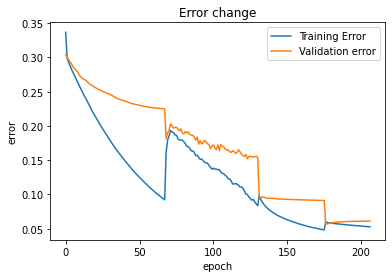

In [10]:
epoch_data = 206

train_err_file = open('output/train_err_' + str(epoch_data) + 'th.err', 'rb')
valid_err_file = open('output/valid_err_' + str(epoch_data) + 'th.err', 'rb')
train_err = pickle.load(train_err_file)
valid_err = pickle.load(valid_err_file)

x = np.arange(len(train_err))
yt = []
yv = []
for err in train_err:
  yt.append(np.sum(err) / len(err))
for err in valid_err:
  yv.append(np.sum(err) / len(err))

plt.plot(x, yt)
plt.plot(x, yv)

plt.legend(["Training Error", "Validation error"])

plt.xlabel('epoch')
plt.ylabel('error')

plt.title('Error change')
plt.show()

# Testing

Import model

In [11]:
model_to_import = 206

model_file = open('output/ANN_' + str(model_to_import) + 'th.model', 'rb')
model = pickle.load(model_file)

## Accuracy Checking of the model on Test set

In [12]:
acc_count = 0

for t in tqdm(test_set):
  data, label = all_data[t]
  output = model.test(data)
  if np.argmax(label) == np.argmax(output):
    acc_count += 1
  
print("\nAccuracy = ", acc_count/len(test_set)*100, "%")

100%|██████████| 705/705 [00:03<00:00, 179.25it/s]
Accuracy =  95.74468085106383 %



## Accuracy Checking of the model on full dataset

In [13]:
acc_count = 0

for t in tqdm(range(len(all_images))):
  data, label = all_data[t]
  output = model.test(data)
  if np.argmax(label) == np.argmax(output):
    acc_count += 1
  
print("\nAccuracy = ", acc_count/len(all_images)*100, "%")

100%|██████████| 5629/5629 [00:30<00:00, 184.02it/s]
Accuracy =  95.34553206608634 %



Checking accuracy on random data

6
6


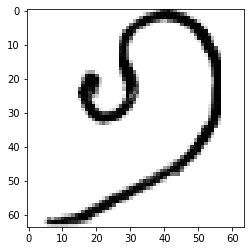

In [14]:
data, label = all_data[np.random.randint(len(all_images))]
img = data.reshape(net_in_img_dim, net_in_img_dim)
plt.imshow(img, cmap='gray')
output = model.test(data)
print(np.argmax(label))
print(np.argmax(output))